# Lid-driven cavity benchmarkwith a D2Q9 Lattice Boltzmann Method

The code implements a simple D2Q9 LBM, with BGK collision operator and uses a Single Relaxation Time.

The initial Julia implementation comes from [https://github.com/Nappael/JuliaLatticeBoltzmann] (MIT license).

The main reference is of course Philip Mocz's repository [https://github.com/pmocz/latticeboltzmann-python] (GPL3 license).

In [ ]:
for t=1:Nt

    %     streaming
    for i=1:9
        f(i,:,:) = circshift(f(i,:,:), [0,ex(i),ey(i)]);
    end
    f(2,1,:) = f(6,1,:);
    f(3,1,:) = f(7,1,:);
    f(9,1,:) = f(5,1,:);
    
    f(6,Nx,:) = f(2,Nx,:);
    f(7,Nx,:) = f(3,Nx,:);
    f(5,Nx,:) = f(9,Nx,:);
    
    f(4,:,1) = f(8,:,1);
    f(3,:,1) = f(7,:,1);
    f(5,:,1) = f(9,:,1);
    
    rhou=f(1,:,Ny)+f(2,:,Ny)+f(6,:,Ny) + ...
        2*(f(4,:,Ny)+f(5,:,Ny)+f(3,:,Ny));
    f(8,:,Ny)=f(4,:,Ny);
    f(9,:,Ny)=f(5,:,Ny) + 1/2*(f(6,:,Ny)-f(2,:,Ny)) + (1/2 * rhou * u0);
    f(7,:,Ny)=f(3,:,Ny) + 1/2*(f(2,:,Ny)-f(6,:,Ny)) - (1/2 * rhou * u0);
    
    rho     = reshape(sum(f), Nx, Ny);
    ux(:,:) = reshape(ex * reshape(f,9,Nx*Ny),Nx,Ny) ./ rho;
    uy(:,:) = reshape(ey * reshape(f,9,Nx*Ny),Nx,Ny) ./ rho;
    ux(1,:)  = 0;
    ux(Nx,:) = 0;
    ux(:,1)  = 0;
    ux(:,Ny) =u0;
    uy(1,:)  = 0;
    uy(Nx,:) = 0;
    uy(:,1)  = 0;
    uy(:,Ny) = 0;
end

Psi=zeros(Nx,Ny);
for i =2:Nx-1
    Psi(i,2:Ny-1) = Psi(i-1,2:Ny-1) - uy(i,2:Ny-1);
end
imshow(Psi');

In [4]:
import Pkg
Pkg.activate(".")
#Pkg.add("PyPlot")
#Pkg.add("Einsum")
#Pkg.add("StaticArrays")
#Pkg.instantiate()

 Activating environment at `~/hattivatti/Project.toml`


In [6]:
using PyPlot, Einsum, StaticArrays, LinearAlgebra
import Random
Random.seed!(42)
# Simulation parameters

const Nx, Ny = 50, 50
const Nt     = 5000
const u0     = 0.1
const ρ0     = 1.0
const Δt     = 1.0
const ΔL     = 1.0
const ν      = 0.01
const τ      = 3ν + 0.5

Re = Nx * abs(u0) / ν
const ex = [0, 1, 1, 0,-1,-1,-1, 0, 1]
const ey = [0, 0, 1, 1, 1, 0,-1,-1,-1]
const S  = [1.0, 1.4, 1.4, 1.0, 1.2, 1.0, 1.2, 1/τ, 1/τ]
const M = [1     1     1     1     1     1     1     1     1
          -4    -1     2    -1     2    -1     2    -1     2
           4    -2     1    -2     1    -2     1    -2     1
           0     1     1     0    -1    -1    -1     0     1
           0    -2     1     0    -1     2    -1     0     1
           0     0     1     1     1     0    -1    -1    -1
           0     0     1    -2     1     0    -1     2    -1
           0     1     0    -1     0     1     0    -1     0
           0     0     1     0    -1     0     1     0    -1]
invM = M \ diagm(S)

struct LatticeState{T}
    ρ::Array{T, 2}    # macroscale density
    f::Array{T, 3}    # particle distribution function
    m::Array{T, 3}  # equillibrium moments for collision
    ux::Array{T, 2}   # macroscale velocity, x component
    uy::Array{T, 2}   # macroscale velocity, y component
    meq::Array{T, 3}  # equillibrium term for collision
    tmp::Array{T, 2}  # place-holder array
end

function LatticeState(Nx,Ny)
    ρ   = zeros(Nx,Ny)
    f   = ones(Nx,Ny,NL)
    m   = similar(f)
    ux  = similar(ρ)
    uy  = similar(ρ)
    meq = similar(f)
    tmp = similar(ρ)

    return LatticeState{Float64}(ρ, f, m, ux, uy, meq, tmp)
end

LatticeState

In [83]:
@inbounds function stream!(f::Array{<:Real}, tmp::Array{<:Real})
    for i in 1:NL
        A = @view f[:,:,i]
        circshift!(tmp, A, (ex[i],0) )
        circshift!(A, tmp, (0,ey[i]) )
    end
end


@inbounds function calculate_meq!(meq::Array{<:Real},
        ρ::Array{<:Real}, ux::Array{<:Real}, uy::Array{<:Real})
    for i=1:Nx, j=1:Ny
        jx = rho(i,j) * ux(i,j);
        jy = rho(i,j) * uy(i,j);
        mEq[1,i,j] =   rho(i,j);
        mEq[2,i,j] =-2*rho(i,j) + 3*(jx^2 + jy^2);
        mEq[3,i,j] =+1*rho(i,j) - 3*(jx^2 + jy^2);
        mEq[4,i,j] =  +jx;
        mEq[5,i,j] =  -jx;
        mEq[6,i,j] =  +jy;
        mEq[7,i,j] =  -jy;
        mEq[8,i,j] =   jx^2 - jy^2;
        mEq[9,i,j] =   jx * jy;
    end
end

@inbounds function collision!(f::Array{<:Real}, meq::Array{<:Real})
    m = zeros(Nx, Ny, NL)
    for i=1:Nx, j=1:Ny
        m[i,j,:] .= M * f[i,j,:]
    end
    
    m .= reshape(M * reshape(f,9,Nx*Ny), NL, Nx, Ny);
    f .= f - reshape(MoverS * reshape(m-mEq,9,Nx*Ny), NL, Nx, Ny);
    for i=1:Nx, j=1:Ny
        f[i,j,:] .= f[i,j,:] .- invM * (m[i,j,:] .- meq[i,j,:])
    end
end

@inbounds function calculate_u!(ux::Array{<:Real}, uy::Array{<:Real},
        f::Array{<:Real}, ρ::Array{<:Real})
    sum!(ρ, f)
    @einsum ux[i,j] = f[i,j,k] * ex[k] / ρ[i,j]
    @einsum uy[i,j] = f[i,j,k] * ey[k] / ρ[i,j]
    
    ux[1,:] .= .0; ux[Nx,:] .= .0; ux[:,1] .= .0; ux[:,Ny] .= u0;
    uy[1,:] .= .0; uy[Nx,:] .= .0; uy[:,1] .= .0; uy[:,Ny] .= .0;
end

@inbounds function correct_F!(F::Array{<:Real}, ρ::Array{<:Real})
    @einsum f[i,j,k] = f[i,j,k] * ρ0 / ρ[i,j]
end

@inbounds function apply_bc!(F::Array{<:Real})
    F[ 1,:,3] = F[ 1,:,7]
    F[ 1,:,4] = F[ 1,:,8]
    F[ 1,:,5] = F[ 1,:,9]
    F[Nx,:,7] = F[Nx,:,3]
    F[Nx,:,8] = F[Nx,:,4]
    F[Nx,:,9] = F[Nx,:,5]
    F[ :,1,2] = F[ :,1,6]
    F[ :,1,3] = F[ :,1,7]
    F[ :,1,9] = F[ :,1,5]
    
    ρ  = F[:,Ny,1] + F[:,Ny,4] + F[:,Ny,8] + 2.0(F[:,Ny,2] + F[:,Ny,3] + F[:,Ny,9])
    ρu = u0 .* ρ ./ (1.0 .+ u0)
    F[:,Ny,5] = F[:,Ny,9] - 1/6*ρu + 1/2*(F[:,Ny,8] - F[:,Ny,4])
    F[:,Ny,6] = F[:,Ny,2] - 2/3*ρu
    F[:,Ny,7] = F[:,Ny,3] - 1/6*ρu + 1/2*(F[:,Ny,4] - F[:,Ny,8])
end

function step!(f::LatticeState, Nt::Int)
    for it in 1:Nt
        calculate_feq!(f.Feq, f.ρ, f.ux,f.uy)
        collision!(f.F, f.Feq)
        stream!(f.F, f.tmp)
        apply_bc!(f.F)
        calculate_u!(f.ux, f.uy, f.F, f.ρ)
    end
end

@inbounds function init!(f::LatticeState)
    f.F .= zeros(Nx, Ny, NL)
    f.F[:, :, :] .= 1.0
    fill!(f.ux, 0.0)
    fill!(f.uy, 0.0)
    sum!(f.ρ, f.F)
    correct_F!(f.F, f.ρ)
end

init! (generic function with 1 method)

  0.229475 seconds (1.03 M allocations: 56.745 MiB, 3.23% gc time, 98.96% compilation time)


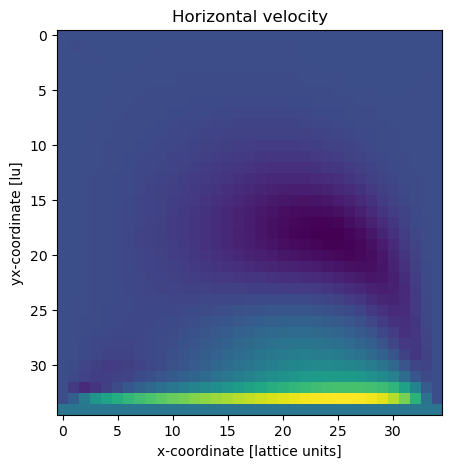

  1.426998 seconds (17.19 M allocations: 1.702 GiB, 5.58% gc time)


PyObject Text(23.999999999999993, 0.5, 'yx-coordinate [lu]')

In [84]:
problem  = LatticeState(Nx, Ny)
init!(problem)
@time step!(problem,   1) # Run simulation the first time to get rid of compilation overhead
@time step!(problem, 1000) # Run simulation (for real!)

figure(figsize=(10,5))
imshow(problem.ρ'); title("Density ρ")
#imshow(ψ'); title("ψ")
imshow(problem.ux'); title("Horizontal velocity")
xlabel("x-coordinate [lattice units]")
ylabel("yx-coordinate [lu]")

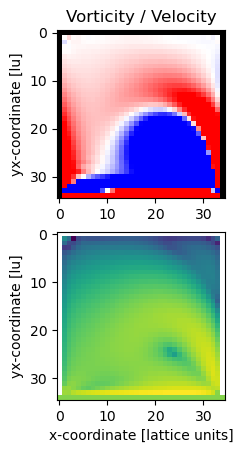

PyObject Text(23.999999999999993, 0.5, 'yx-coordinate [lu]')

In [85]:
ux = copy(problem.ux)
uy = copy(problem.uy)
velocity  = ux .^2 .+ uy .^ 2
vorticity = (circshift(ux, (0,+1)) .- circshift(ux, (0,-1))) .-
            (circshift(uy, (+1,0)) .- circshift(uy, (-1,0)))
vorticity[1,:] .= NaN
vorticity[:,1] .= NaN
vorticity[Nx,:].= NaN
bwr = PyPlot.cm.bwr.copy(); bwr.set_bad("black")

subplot(2,1,1); imshow(vorticity', cmap=bwr); clim([-.03, +.03]);
title("Vorticity / Velocity")
ylabel("yx-coordinate [lu]")
subplot(2,1,2); imshow(log10.(abs.(velocity')))
xlabel("x-coordinate [lattice units]")
ylabel("yx-coordinate [lu]")

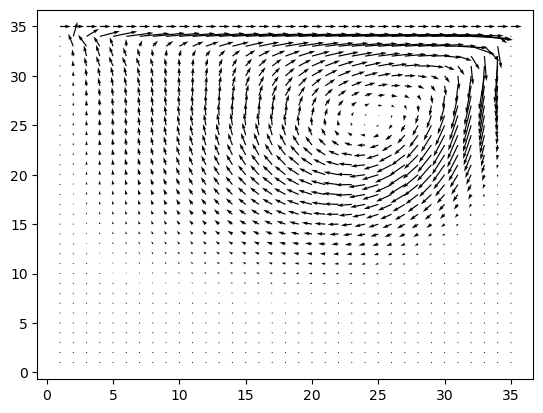

PyObject <matplotlib.quiver.Quiver object at 0x7fb97226f940>

In [86]:
quiver([i for i=1:Nx, j=1:Ny], [j for i=1:Nx, j=1:Ny], problem.ux, problem.uy)